# <h1 style="text-align: center; color:magenta"> Prediction Section </h1>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## <h2 style="text-align: left; color:cyan"> Loading Data </h2>

Load data from the prepared file

In [6]:
df = pd.read_pickle("prediction_features_df.pkl")

## <h2 style="text-align: left; color:cyan"> Preprocessing & Feature Engineering </h2>
Some features such as member count, transport insurance and vehicle expenses and mean_age of the family, living in urban/rural neighborhood were created in the previous secion, i.e. the sheet loading section.

In [7]:
# Storing the info of the original dataframe
import io
buffer = io.StringIO()
df.info(buf=buffer)
info_lines = buffer.getvalue().splitlines()
original_info_df = (pd.DataFrame([x.split() for x in info_lines[5:-2]], columns=info_lines[3].split())
       .drop(["#",'Count'],axis=1)
       .rename(columns={'Non-Null':'Non-Null Count'})
       .astype({"Non-Null Count":int}))
original_info_df.sort_values(by="Non-Null Count", ascending=False)
del buffer, info_lines

In [8]:
original_info_df

,Column,Non-Null Count,Dtype
0,Address,151824,int64
1,Urban,151824,bool
2,Year,151824,int64
3,Fasl,151824,int64
4,khanevartype,151824,int64
5,weight,151824,float64
6,province,151824,object
7,town,151824,int64
8,member_cnt,151824,int64
9,active_member_cnt,118166,float64


### <h3 style="text-align: left; color:cyan"> Filling missing data </h3>

Our target column is "transportation_cost", so we will drop rows with said column being NaN.
We fill the NaN values of some features with few NaN count with zero, only the ones that make sense to do so, for features with many NaN values, we store their column names and decide later to be included in our model features or not.

In [9]:
df.dropna(subset=["transportation_cost"], inplace=True)


df.fillna({"subsidy":0}, inplace=True)
df.fillna({"misc_income":0}, inplace=True)
df.fillna({"active_member_cnt":0}, inplace=True)
df.fillna({"communication_expenses":0}, inplace=True)
df.fillna({"edible_expenses":0}, inplace=True)

# Tenure column has only 4 NaN values which we change to "other" value
df.fillna({"tenure": "Other"}, inplace=True)

# columns with more than half of the data being null
df.fillna({"netincome_w_y": 0}, inplace=True)
df.fillna({"vehicle_expenses": 0}, inplace=True)
df.fillna({"income_s_y": 0}, inplace=True)
df.fillna({"transport_insurance_expenses": 0}, inplace=True)
df.fillna({"highly_educated_member_cnt": 0}, inplace=True)
df.fillna({"dining_expenses": 0}, inplace=True)

# We drop town column since it does not add any value to the model, towns with same number are considered as the same
df.drop(columns=["town"], inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137600 entries, 0 to 151823
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Address                       137600 non-null  int64  
 1   Urban                         137600 non-null  bool   
 2   Year                          137600 non-null  int64  
 3   Fasl                          137600 non-null  int64  
 4   khanevartype                  137600 non-null  int64  
 5   weight                        137600 non-null  float64
 6   province                      137600 non-null  object 
 7   member_cnt                    137600 non-null  int64  
 8   active_member_cnt             137600 non-null  float64
 9   mean_age                      137600 non-null  float64
 10  highly_educated_member_cnt    137600 non-null  float64
 11  vehicle                       137600 non-null  bool   
 12  motorcycle                    137600 non-null  bo

In [11]:
df["total_income"] = df.netincome_w_y + df.income_s_y + df.subsidy + df.misc_income
df = df.drop(columns=["netincome_w_y", "income_s_y", "subsidy", "misc_income"])

Since khanevartype has only two values (1,2) we convert it (0,1) by just subtracting 1 from it.
Then also convert it to Boolean, it reduces data volume in memory.

In [12]:
df['khanevartype'] = (df['khanevartype'] - 1)

Converting boolean columns to int

In [13]:
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)


In [14]:
duplicate_addresses = df.loc[df.Address.duplicated(), :].Address.unique().shape[0]

There are 36792 families with info being present in different years. there is no reason to group the result for those families and we treat them as separate data since we are going to drop the Address columns later on.

In [17]:
df = df.loc[(df.transportation_cost < 3e+08) & 
            (df.communication_expenses < 1e+08) &
            (df.dining_expenses < 4e+08) &
            (df.transport_insurance_expenses < 1.5e+08) &
            (df.vehicle_expenses < 1e+10) &
            (df.total_income > -2e10), :]


### <h3 style="text-align: left; color:cyan"> Splitting train, validation & test data </h4>

In [18]:
X_test = df.loc[(df.Fasl==4) & (df.Year==1401), :]
y_test = X_test.pop("transportation_cost")

X = df.loc[~df.index.isin(X_test.index), :]
y = X.pop("transportation_cost")

X_train, X_val, y_train, y_val = train_test_split(X,y, random_state = 42, test_size = 0.25)


Investigation correlation of features with target variable

In [19]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y, n_neighbors=3, random_state=42)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X.select_dtypes((int, float)), 
                            y)
mi_scores

Address                         0.213372
communication_expenses          0.207205
vehicle                         0.178656
total_income                    0.173828
edible_expenses                 0.150697
transport_insurance_expenses    0.145097
weight                          0.142602
vehicle_expenses                0.141056
Year                            0.063756
dining_expenses                 0.050218
member_cnt                      0.044245
highly_educated_member_cnt      0.040807
mean_age                        0.039023
active_member_cnt               0.038361
motorcycle                      0.016603
Urban                           0.004263
Fasl                            0.003846
khanevartype                    0.002716
bicycle                         0.000159
Name: MI Scores, dtype: float64

In [20]:
less_correlated_feats = mi_scores[mi_scores<0.05].index.to_list()
less_correlated_feats

['member_cnt',
 'highly_educated_member_cnt',
 'mean_age',
 'active_member_cnt',
 'motorcycle',
 'Urban',
 'Fasl',
 'khanevartype',
 'bicycle']

### <h3 style="text-align: left; color:cyan"> Feature Scaling </h4>

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [27]:
categorical_columns = ["province"]

In [28]:
excluded_cols = set(["Address"] + categorical_columns + less_correlated_feats)

In [29]:
# one-hot encode for province
df_province_dummies = pd.get_dummies(df[["province"]], drop_first=True)
train_province = df_province_dummies.loc[X_train.index, :]
val_province = df_province_dummies.loc[X_val.index, :]
test_province = df_province_dummies.loc[X_test.index, :]

In [30]:
# now we drop excluded columns from xtrain, xval and xtest
X_train_numeric = X_train.drop(excluded_cols, axis=1).astype(float)
X_val_numeric = X_val.drop(excluded_cols, axis=1).astype(float)
X_test_numeric = X_test.drop(excluded_cols, axis=1).astype(float)


In [31]:
min_max_scaler = MinMaxScaler()

X_train_minmax = min_max_scaler.fit(X_train.drop(excluded_cols, axis=1))

# The following 3 data do not contain categorical variables
X_train_numeric.loc[:, :] = min_max_scaler.transform(X_train_numeric)
X_val_numeric.loc[:, :] = min_max_scaler.transform(X_val_numeric)
X_test_numeric.loc[:, :] = min_max_scaler.transform(X_test_numeric)

In [23]:
# now we merge the above dataframes with the province and tenure dummies horiontally
# Features with categorical included
X_train_w_cat = pd.concat((train_province, X_train_numeric), axis=1)
X_val_w_cat = pd.concat((val_province, X_val_numeric), axis=1)
X_test_w_cat = pd.concat((test_province, X_test_numeric), axis=1)


Address


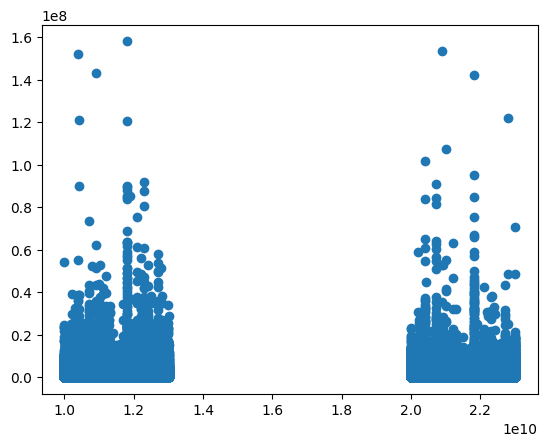

Urban


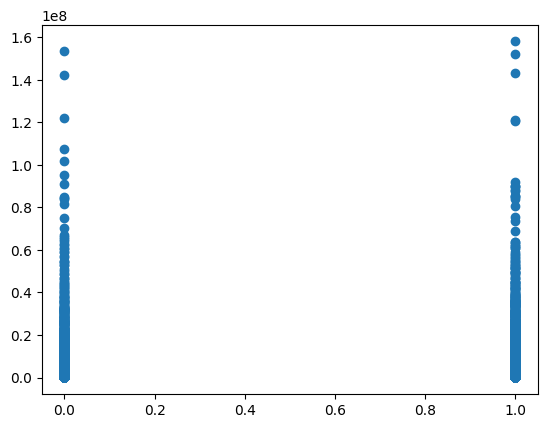

Year


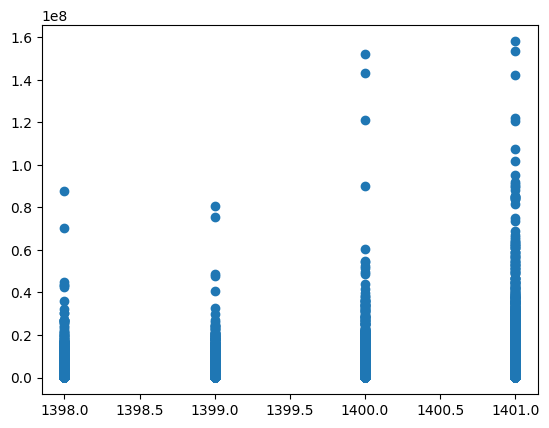

Fasl


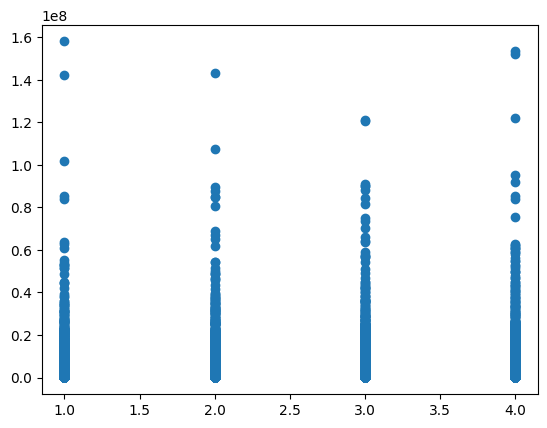

khanevartype


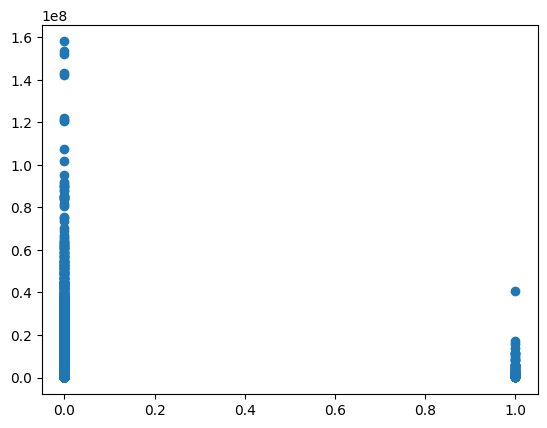

province


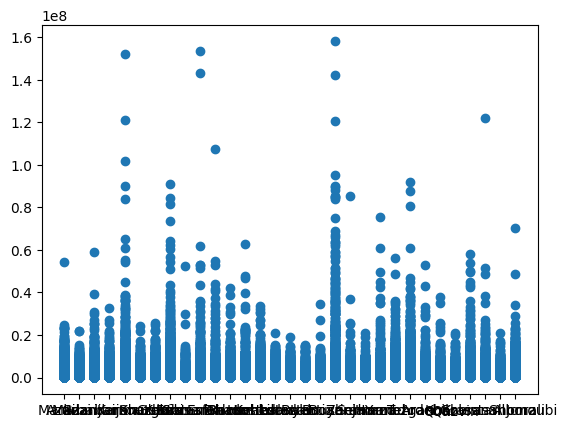

member_cnt


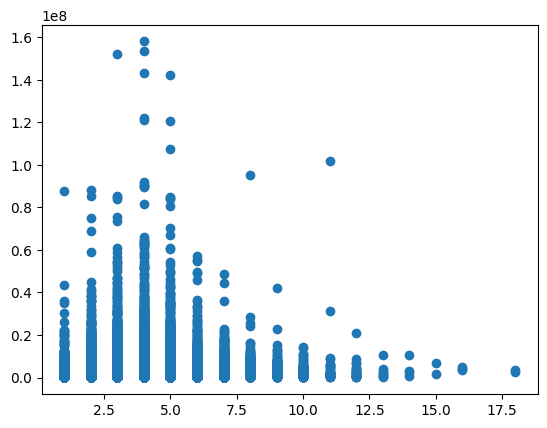

active_member_cnt


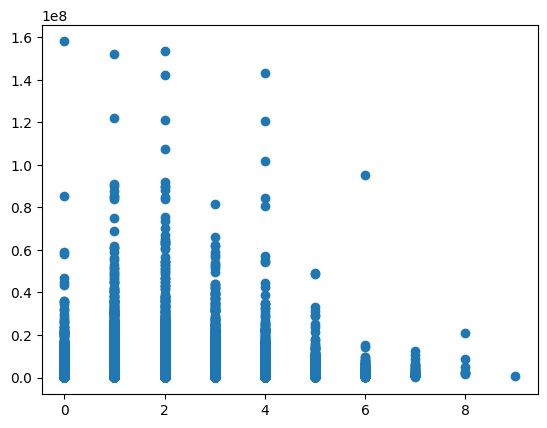

mean_age


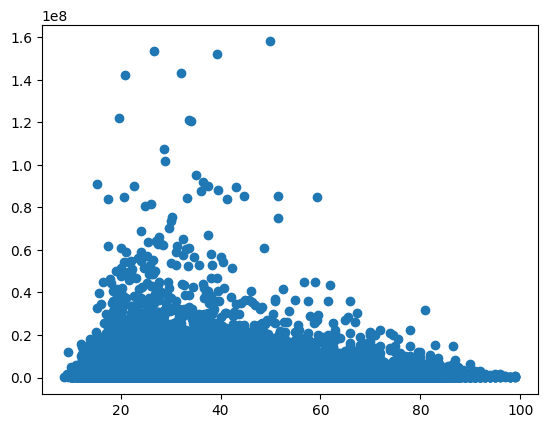

highly_educated_member_cnt


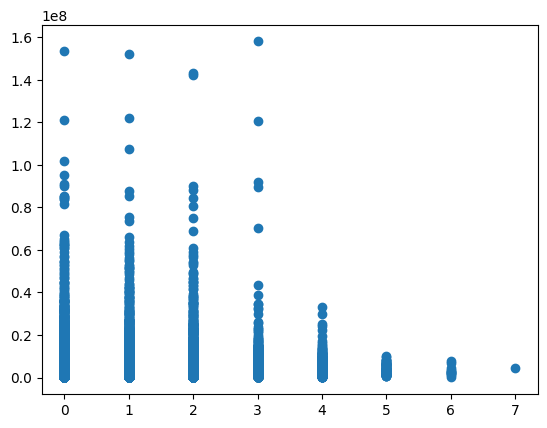

tenure


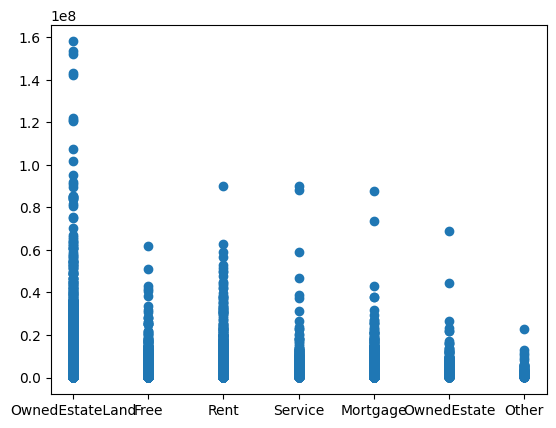

vehicle


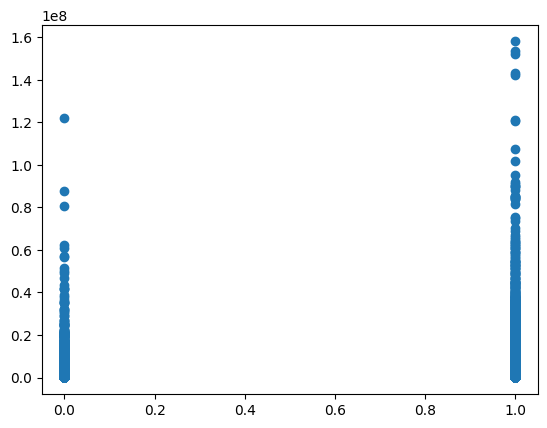

motorcycle


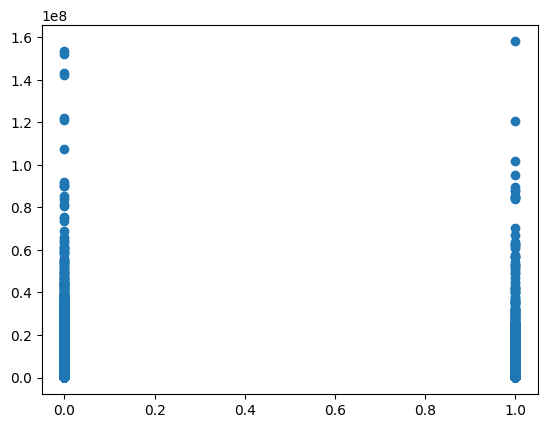

bicycle


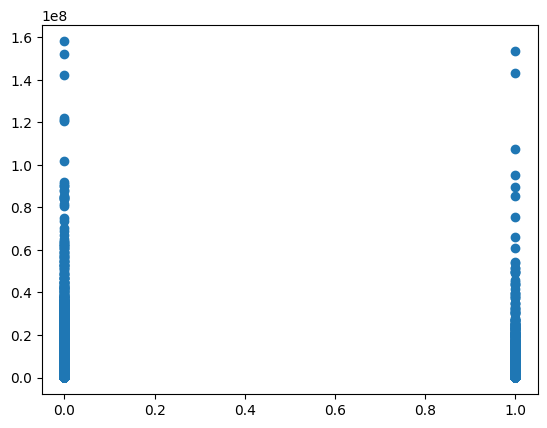

transportation_cost


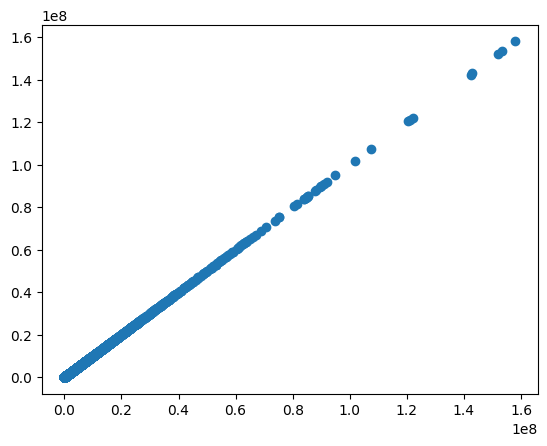

communication_expenses


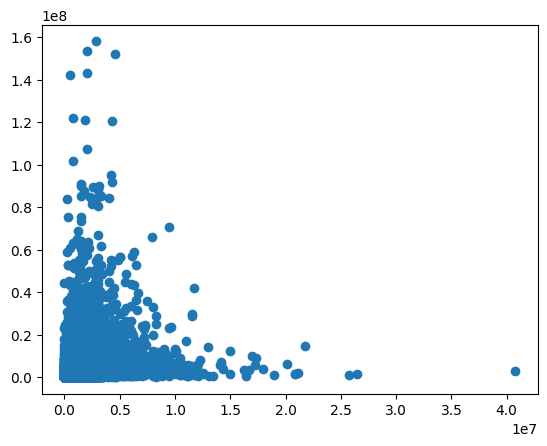

dining_expenses


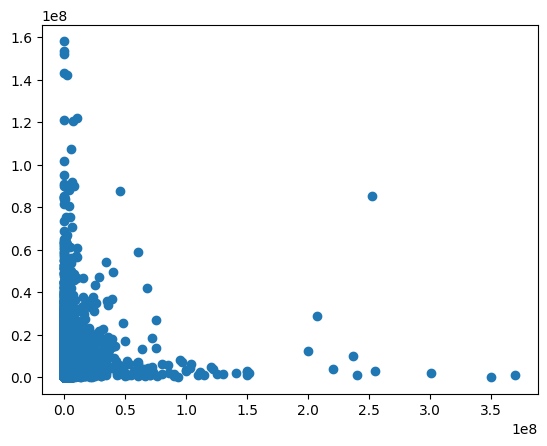

transport_insurance_expenses


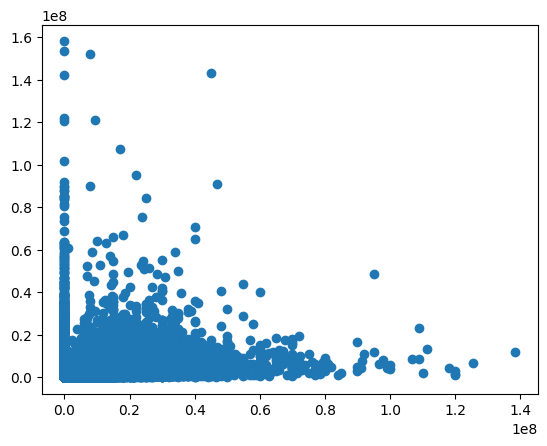

vehicle_expenses


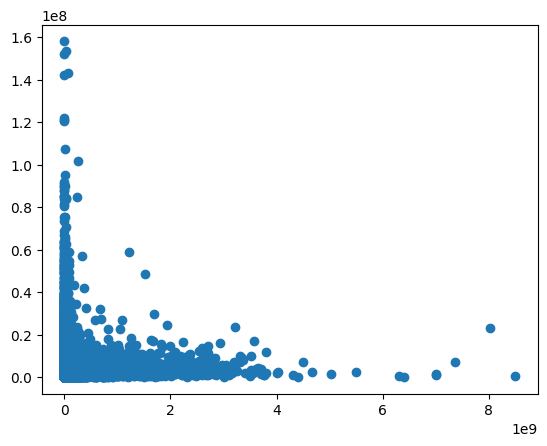

total_income


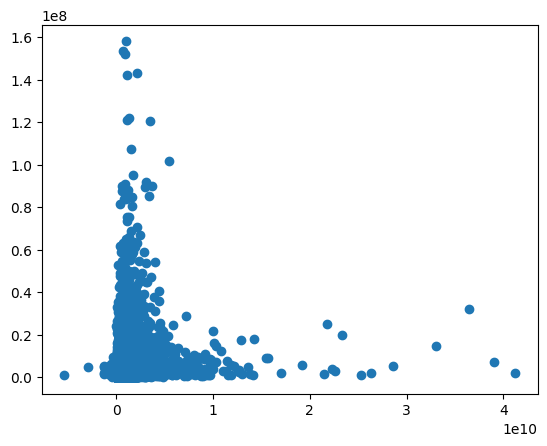

In [24]:
for col in df.columns:
    print(col)
    plt.scatter(df[ col], df.transportation_cost)
    plt.show()

## <h2 style="text-align: left; color:cyan"> Regression Models </h2>

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

from xgboost import XGBRegressor

### <h3 style="text-align: left; color:cyan"> Random Forest Regression Model - w/o categoricals </h3>

In [38]:
rf_reg = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf_reg.fit(X_train_numeric, y_train)
y_pred = rf_reg.predict(X_val_numeric)
print("Train data accuracy:",r2_score(y_true = y_train, y_pred=rf_reg.predict(X_train_numeric)))
print("Validation data accuracy:",r2_score(y_true = y_val, y_pred=y_pred))

Train data accuracy: 0.8834201410339909
Validation data accuracy: 0.20826542949267413


The above model is clearly not working well.

### <h3 style="text-align: left; color:cyan"> Multiple Linear Regression Model - w/o categoricals </h3>

In [44]:
poly_transformer = PolynomialFeatures(2, include_bias=True, interaction_only=False)
train_poly_features = poly_transformer.fit_transform(X_train_numeric)
val_poly_features = poly_transformer.transform(X_val_numeric)

model = LinearRegression()
model.fit(train_poly_features, y_train)

train_y_pred = model.predict(train_poly_features)
validate_y_pred = model.predict(val_poly_features)
train_r2 = r2_score(y_train, train_y_pred)
validation_r2 = r2_score(y_val, validate_y_pred)
print("train R2= ",train_r2, "\nvalidation R2= ",validation_r2, "\nR2 diff= ", train_r2 - validation_r2)

train R2=  0.24014764092750607 
validation R2=  0.19913910700893267 
R2 diff=  0.0410085339185734


### <h3 style="text-align: left; color:cyan"> Random Forest Regression Model - with categoricals </h3>

In [45]:
rf_reg = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
rf_reg.fit(X_train_w_cat, y_train)
y_pred_train = rf_reg.predict(X_train_w_cat)
y_pred_val = rf_reg.predict(X_val_w_cat)
print("Train data accuracy:",r2_score(y_true = y_train, y_pred=y_pred_train))
print("Validation data accuracy:",r2_score(y_true = y_val, y_pred=y_pred_val))

Train data accuracy: 0.8902360208282822
Validation data accuracy: 0.2273913099646251


### <h3 style="text-align: left; color:cyan"> Multiple Linear Regression Model - with categoricals </h3>

In [46]:
poly_transformer = PolynomialFeatures(1, include_bias=True, interaction_only=True)
train_poly_features = poly_transformer.fit_transform(X_train_w_cat)
val_poly_features = poly_transformer.transform(X_val_w_cat)

model = LinearRegression()
model.fit(train_poly_features, y_train)

train_y_pred = model.predict(train_poly_features)
validate_y_pred = model.predict(val_poly_features)
train_r2 = r2_score(y_train, train_y_pred)
validation_r2 = r2_score(y_val, validate_y_pred)
print("train R2= ",train_r2, "\nvalidation R2= ",validation_r2, "\nR2 diff= ", train_r2 - validation_r2)

train R2=  0.22830771202200706 
validation R2=  0.24193479733637047 
R2 diff=  -0.013627085314363407


### <h3 style="text-align: left; color:cyan"> Hist GB Regression Model - w & w/o categoricals </h3>

In [47]:
hgb_reg = HistGradientBoostingRegressor(loss="squared_error",
                                        max_iter=3000,
                                        learning_rate=0.005,
                                        n_iter_no_change=30,
                                        random_state=42)
hgb_reg.fit(X_train_w_cat, y_train)
y_pred_train = hgb_reg.predict(X_train_w_cat)
y_pred_val = hgb_reg.predict(X_val_w_cat)
print("Train data accuracy:",r2_score(y_true = y_train, y_pred=y_pred_train))
print("Validation data accuracy:",r2_score(y_true = y_val, y_pred=y_pred_val))

Train data accuracy: 0.35309759251295514
Validation data accuracy: 0.28259049650329304


In [48]:
hgb_reg = HistGradientBoostingRegressor(loss="squared_error",
                                        max_iter=3000,
                                        learning_rate=0.005,
                                        n_iter_no_change=30,
                                        random_state=42)
hgb_reg.fit(X_train_numeric, y_train)
y_pred_train = hgb_reg.predict(X_train_numeric)
y_pred_val = hgb_reg.predict(X_val_numeric)
print("Train data accuracy:",r2_score(y_true = y_train, y_pred=y_pred_train))
print("Validation data accuracy:",r2_score(y_true = y_val, y_pred=y_pred_val))

Train data accuracy: 0.3213437029943915
Validation data accuracy: 0.25495476646783055


### <h3 style="text-align: left; color:cyan"> SGD Regressor </h3>

In [49]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, loss='squared_error')
sgd_reg.fit(X_train_numeric, y_train)
y_pred_train = sgd_reg.predict(X_train_numeric)
y_pred_val = sgd_reg.predict(X_val_numeric)
print("Train data accuracy:",r2_score(y_true = y_train, y_pred=y_pred_train))
print("Validation data accuracy:",r2_score(y_true = y_val, y_pred=y_pred_val))

Train data accuracy: 0.20474800017571648
Validation data accuracy: 0.22407897386256925


In [50]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, loss='squared_error')
sgd_reg.fit(X_train_w_cat, y_train)
y_pred_train = sgd_reg.predict(X_train_w_cat)
y_pred_val = sgd_reg.predict(X_val_w_cat)
print("Train data accuracy:",r2_score(y_true = y_train, y_pred=y_pred_train))
print("Validation data accuracy:",r2_score(y_true = y_val, y_pred=y_pred_val))

Train data accuracy: 0.21929239065994088
Validation data accuracy: 0.23968556664089125


### <h3 style="text-align: left; color:cyan"> Huber Regressor </h3>

In [56]:
from sklearn.linear_model import HuberRegressor
huber_reg = HuberRegressor(max_iter=1000, epsilon=5)
huber_reg.fit(X_train_w_cat, y_train)
y_pred_train = huber_reg.predict(X_train_w_cat)
y_pred_val = huber_reg.predict(X_val_w_cat)
print("Train data accuracy:",r2_score(y_true = y_train, y_pred=y_pred_train))
print("Validation data accuracy:",r2_score(y_true = y_val, y_pred=y_pred_val))

Train data accuracy: 0.19024089132740452
Validation data accuracy: 0.20511194197935567


### <h3 style="text-align: left; color:cyan"> XG Boost Regressor </h3>

In [ ]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.005, random_state=42)
xgb_reg.fit(X_train_w_cat, y_train)
y_pred_train = xgb_reg.predict(X_train_w_cat)
y_pred_val = xgb_reg.predict(X_val_w_cat)
print("Train data accuracy:",r2_score(y_true = y_train, y_pred=y_pred_train))
print("Validation data accuracy:",r2_score(y_true = y_val, y_pred=y_pred_val))

Train data accuracy: 0.4405716737115146
Validation data accuracy: 0.28198535095845567


In [ ]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.005, random_state=42)
xgb_reg.fit(X_train_numeric, y_train)
y_pred_train = xgb_reg.predict(X_train_numeric)
y_pred_val = xgb_reg.predict(X_val_numeric)
print("Train data accuracy:",r2_score(y_true = y_train, y_pred=y_pred_train))
print("Validation data accuracy:",r2_score(y_true = y_val, y_pred=y_pred_val))

Train data accuracy: 0.38619397821873314
Validation data accuracy: 0.2552776570484627
